This project aims to forecast EV charging station congestion and identify infrastructure stress points using historical charging session data. The objective is to help charging operators and utilities plan capacity upgrades and reduce peak-time waiting and grid stress.

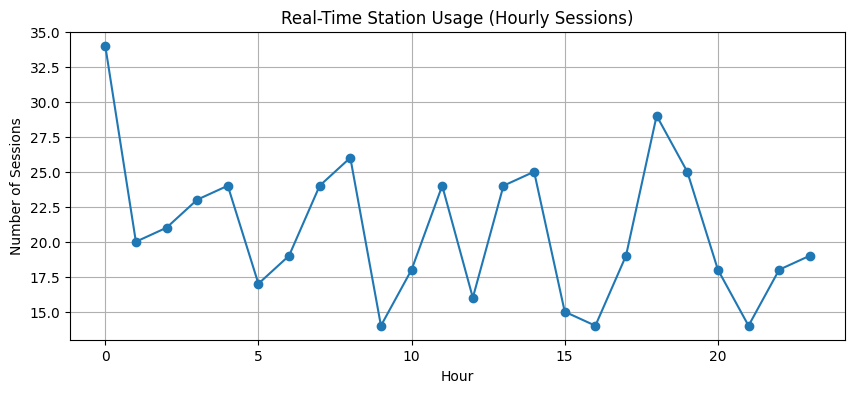

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("EV charging stations data.csv", parse_dates=["start_time","end_time"])

df['duration_min'] = (df['end_time'] - df['start_time']).dt.total_seconds()/60
df['hour'] = df['start_time'].dt.hour

#Analyze Real-Time Station Usage Logs
hourly_usage = df.groupby('hour')['session_id'].count().reset_index()
plt.figure(figsize=(10,4))
plt.plot(hourly_usage['hour'], hourly_usage['session_id'], marker='o')
plt.xlabel("Hour")
plt.ylabel("Number of Sessions")
plt.title("Real-Time Station Usage (Hourly Sessions)")
plt.grid(True)
plt.show()

#deviding the day into time blocks
def time_block(h):
    if 6 <= h < 12:
        return "Morning"
    elif 12 <= h < 18:
        return "Afternoon"
    elif 18 <= h < 22:
        return "Evening"
    else:
        return "Night"

df['time_block'] = df['hour'].apply(time_block)
hourly_usage = df.groupby('hour')['session_id'].count()
block_usage = df.groupby('time_block')['session_id'].count()


In [53]:
df.head()

,session_id,station_id,start_time,end_time,queue_length,location_lat,location_lon,duration_min,hour,time_block
0,1,4,2025-01-01 20:20:00,2025-01-01 20:54:00,2,18.577969,73.759685,34.0,20,Evening
1,2,2,2025-01-12 22:50:00,2025-01-13 00:24:00,2,18.586618,73.760112,94.0,22,Night
2,3,3,2025-01-02 10:05:00,2025-01-02 11:17:00,1,18.572200,73.793855,72.0,10,Morning
3,4,2,2025-01-04 22:31:00,2025-01-04 23:11:00,0,18.530424,73.752476,40.0,22,Night
4,5,4,2025-01-07 06:26:00,2025-01-07 07:44:00,1,18.504667,73.797376,78.0,6,Morning


In [59]:
#for high demand stations
hourly_usage = hourly_usage.reset_index()

df['day'] = df['start_time'].dt.dayofweek
df['is_weekend'] = df['day'] >= 5

weekend_usage = df.groupby('is_weekend')['session_id'].count()


plt.figure(figsize=(10,4))
plt.plot(hourly_usage['hour'], hourly_usage['rolling_3h'], marker='o')
plt.xlabel("Hour")
plt.ylabel("Smoothed Sessions")
plt.title("Predicted High-Demand Periods (Rolling 3-Hour Window)")
plt.grid(True)
plt.show()

predicted_peak_hours = hourly_usage.sort_values('rolling_3h', ascending=False).head(5)
plt.bar(['Weekday','Weekend'], weekend_usage.values)
plt.ylabel("Sessions")
plt.title("Charging Demand: Weekday vs Weekend")
plt.show()

ValueError: cannot insert level_0, already exists

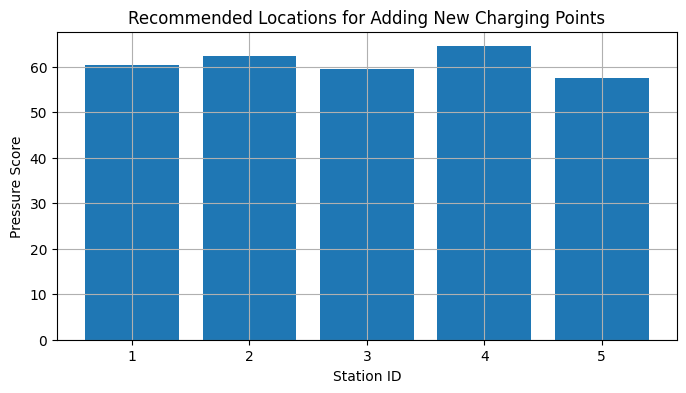

In [ ]:
#RECOMMENDED LOCATIONS FOR NEW CHARGING POINTS

# 1. Calculate average duration per station
station_load = df.groupby('station_id')['duration_min'].mean().reset_index()
station_load.rename(columns={'duration_min': 'avg_duration'}, inplace=True)

# 2. Calculate average queue length per station
station_queue = df.groupby('station_id')['queue_length'].mean().reset_index()
station_queue.rename(columns={'queue_length': 'avg_queue'}, inplace=True)

# 3. Merge both
recommend_locations = pd.merge(station_load, station_queue, on='station_id')

# 4. Create pressure score
recommend_locations['pressure_score'] = (
    recommend_locations['avg_duration'] * 0.6 +
    recommend_locations['avg_queue'] * 0.4
)

# 5. Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(
    recommend_locations['station_id'].astype(str),
    recommend_locations['pressure_score']
)
plt.xlabel("Station ID")
plt.ylabel("Pressure Score")
plt.title("Recommended Locations for Adding New Charging Points")
plt.grid(True)
plt.show()

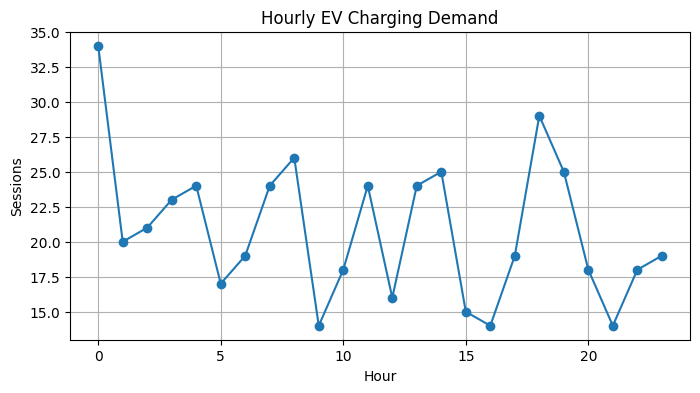

In [ ]:
hourly = df.groupby('hour').size().reset_index(name='sessions')
plt.figure(figsize=(8,4))
plt.plot(hourly['hour'], hourly['sessions'], marker='o')
plt.xlabel("Hour")
plt.ylabel("Sessions")
plt.title("Hourly EV Charging Demand")
plt.grid(True)
plt.show()

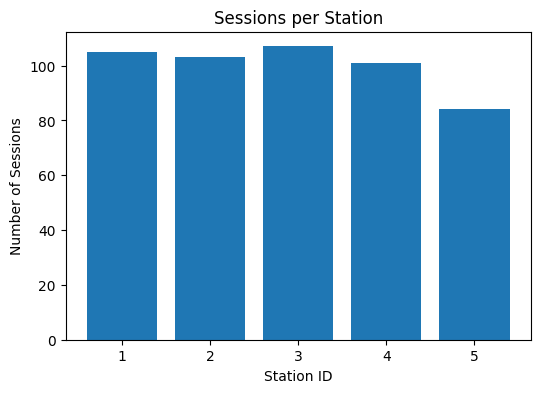

In [ ]:
station_sessions = df['station_id'].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(station_sessions.index, station_sessions.values)
plt.xlabel("Station ID")
plt.ylabel("Number of Sessions")
plt.title("Sessions per Station")
plt.show()

In [ ]:
# Predicting Queue Lengths
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X = df[['hour', 'duration_min', 'station_id']]
y = df['queue_length']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, preds))


MAE: 1.791104761904762


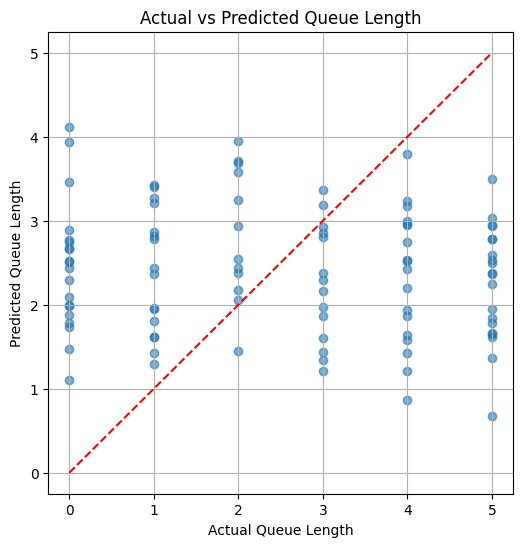

In [ ]:
#actual vs predicted plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Queue Length")
plt.ylabel("Predicted Queue Length")
plt.title("Actual vs Predicted Queue Length")
plt.grid(True)
plt.show()


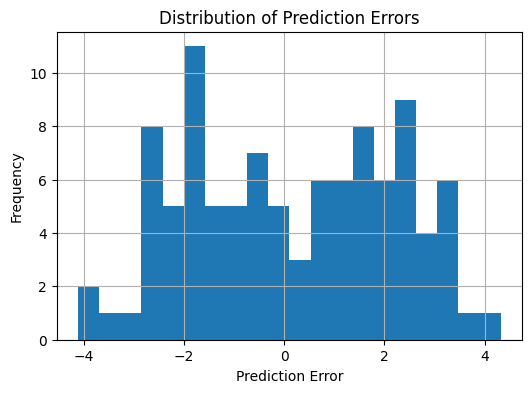

In [ ]:
#error
errors = y_test - preds

plt.figure(figsize=(6,4))
plt.hist(errors, bins=20)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.grid(True)
plt.show()


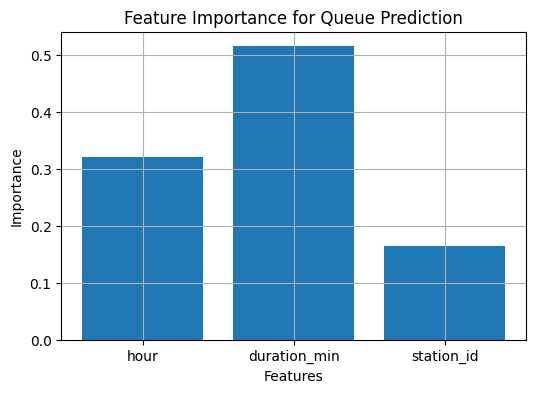

In [ ]:
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(6,4))
plt.bar(features, importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance for Queue Prediction")
plt.grid(True)
plt.show()

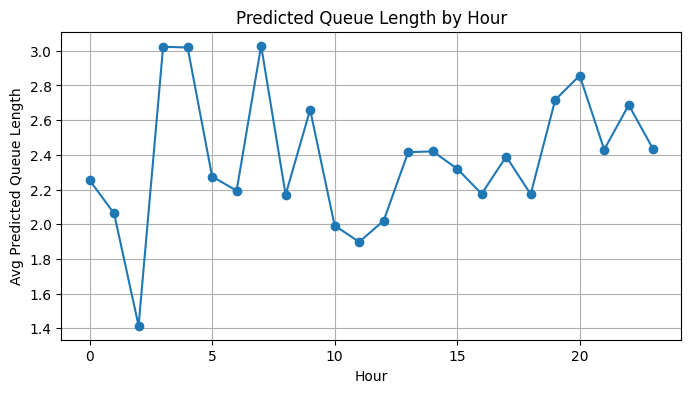

In [ ]:
pred_df = X_test.copy()
pred_df['predicted_queue'] = preds

hourly_pred = pred_df.groupby('hour')['predicted_queue'].mean()

plt.figure(figsize=(8,4))
plt.plot(hourly_pred.index, hourly_pred.values, marker='o')
plt.xlabel("Hour")
plt.ylabel("Avg Predicted Queue Length")
plt.title("Predicted Queue Length by Hour")
plt.grid(True)
plt.show()

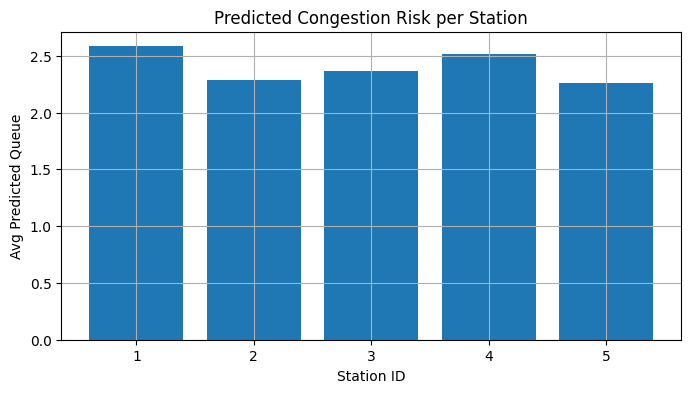

In [ ]:
pred_df['station_id'] = X_test['station_id'].values
station_risk = pred_df.groupby('station_id')['predicted_queue'].mean()

plt.figure(figsize=(8,4))
plt.bar(station_risk.index.astype(str), station_risk.values)
plt.xlabel("Station ID")
plt.ylabel("Avg Predicted Queue")
plt.title("Predicted Congestion Risk per Station")
plt.grid(True)
plt.show()


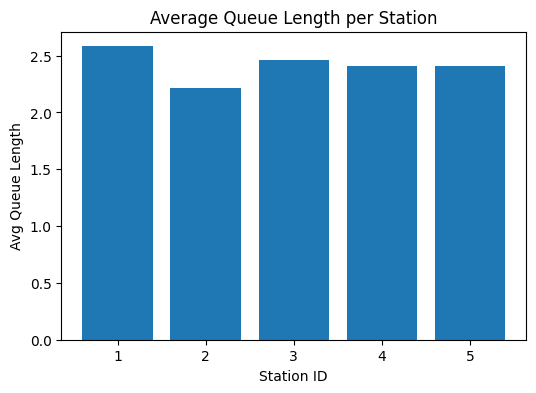

In [ ]:
avg_queue = df.groupby('station_id')['queue_length'].mean()

plt.figure(figsize=(6,4))
plt.bar(avg_queue.index, avg_queue.values)
plt.xlabel("Station ID")
plt.ylabel("Avg Queue Length")
plt.title("Average Queue Length per Station")
plt.show()

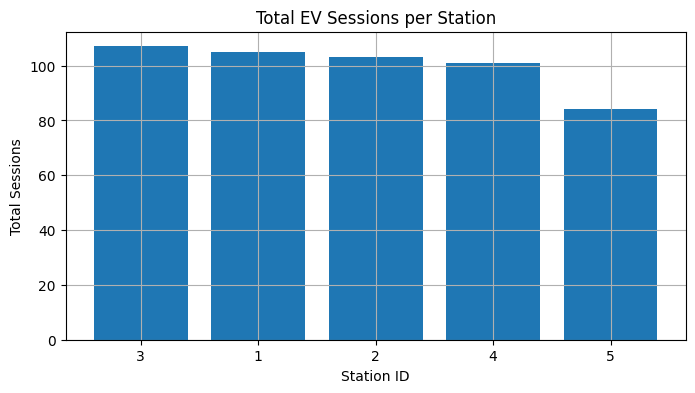

In [ ]:
station_sessions = df['station_id'].value_counts().reset_index()
station_sessions.columns = ['station_id', 'total_sessions']

plt.figure(figsize=(8,4))
plt.bar(station_sessions['station_id'].astype(str), station_sessions['total_sessions'])
plt.xlabel("Station ID")
plt.ylabel("Total Sessions")
plt.title("Total EV Sessions per Station")
plt.grid(True)
plt.show()

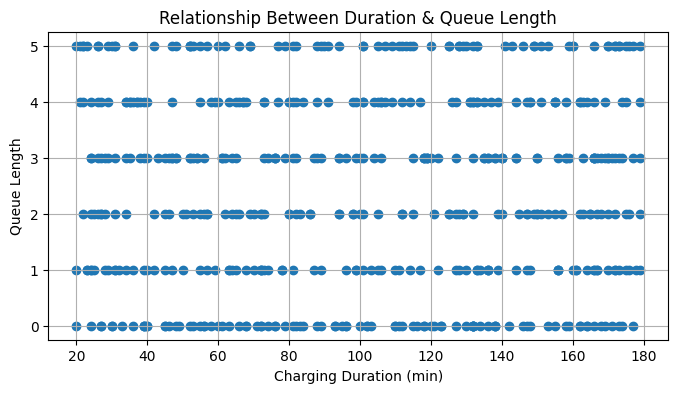

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(df['duration_min'], df['queue_length'])
plt.xlabel("Charging Duration (min)")
plt.ylabel("Queue Length")
plt.title("Relationship Between Duration & Queue Length")
plt.grid(True)
plt.show()

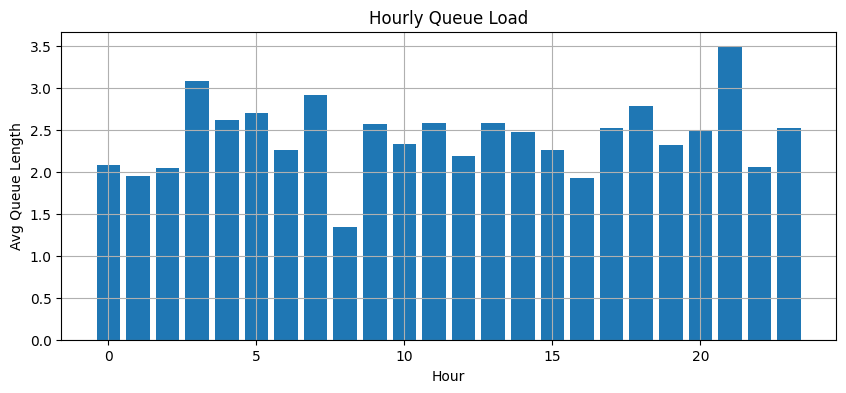

In [ ]:
heatmap_data = df.groupby(['hour'])['queue_length'].mean().reset_index()

plt.figure(figsize=(10,4))
plt.bar(heatmap_data['hour'], heatmap_data['queue_length'])
plt.xlabel("Hour")
plt.ylabel("Avg Queue Length")
plt.title("Hourly Queue Load")
plt.grid(True)
plt.show()

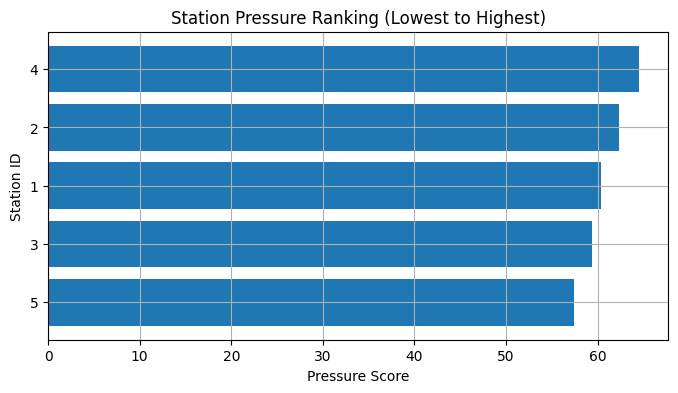

In [ ]:
sorted_data = recommend_locations.sort_values('pressure_score', ascending=True)

plt.figure(figsize=(8,4))
plt.barh(sorted_data['station_id'].astype(str), sorted_data['pressure_score'])
plt.xlabel("Pressure Score")
plt.ylabel("Station ID")
plt.title("Station Pressure Ranking (Lowest to Highest)")
plt.grid(True)
plt.show()

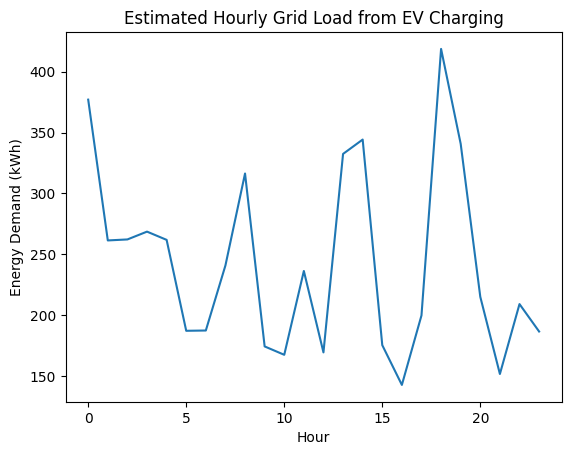

In [ ]:
#energy calculations
df['energy_kwh'] = (df['duration_min'] / 60) * 7  # assume 7 kW charger
hourly_energy = df.groupby('hour')['energy_kwh'].sum()
plt.plot(hourly_energy.index, hourly_energy.values)
plt.xlabel("Hour")
plt.ylabel("Energy Demand (kWh)")
plt.title("Estimated Hourly Grid Load from EV Charging")
plt.show()


Conclusion

The analysis shows that EV charging demand is highly time-dependent, with peak stress occurring during evening and night hours. The stress index and ML model together help identify high-risk stations and peak grid load windows, enabling proactive infrastructure planning and congestion mitigation.

Limitations

This study is based on limited historical data and assumes constant charger power. Real-world deployment would require real-time data integration, station-level power ratings, and weather or traffic influence.